In [25]:
%load_ext autoreload
%autoreload 2


from data.utility import read_network_file, distance
from sortedcontainers import SortedKeyList
from env import constant
import math
import random
import csv

import numpy as np
import matplotlib.pyplot as plt

filepath = "./data/nsf/network.txt"

data_rate = [100, 200, 400]

#Assuming that the requests are granted using QPSK
nb_slots = [math.ceil(d/2*(1+constant.roll_off_factor)/12.5)+1 for d in data_rate]

rate_and_slots = [(data_rate[i], nb_slots[i]) for i in range(len(data_rate))]
data_rate_distribution = [0.45, 0.3, 0.25]

def compute_pair_weight(nodedf):
    d = dict(zip(nodedf['nid'].values, nodedf['population'].values))
    coord = dict(zip(nodedf['nid'], zip(nodedf['lat'].values, nodedf['long'].values)))
    weight = {}
    sum_weight = 0
    list_nid = list(nodedf['nid'].values)
    for nid1 in list_nid:
        for nid2 in list_nid:
            if nid2 <= nid1:
                continue

            w = math.log10(10 + (d[nid1] * d[nid2] / (distance(coord[nid1], coord[nid2]) * 1E3)))
            weight[(nid1, nid2)] = w
            weight[(nid2, nid1)] = w
            sum_weight += 2*w

    for nid1 in list_nid:
        for nid2 in list_nid:
            if nid1 == nid2:
                continue
            weight[(nid1, nid2)] = weight[(nid1, nid2)]/sum_weight
    return weight

'''
Params explanation:
@filepath: path to network file
@nb_slot: max slot per fiber
@max_spectral_usage: maximum spectral usage on a single link
@max_request_added_per_time_unit: maximum request added for 1 time instant
@time_unit: maximum time unit
@min_duration, @max_duration: minimum and maximum duration of each request
'''
def generate_request_set(filepath, randseed=0, nb_slot=380, max_spectral_usage=0.7, max_request_added_per_time_unit=20, time_unit=100, min_duration=4, max_duration=8):
    random.seed(randseed)
    nodedf, adjacent = read_network_file(filepath)
    weight: dict = compute_pair_weight(nodedf)
    list_sd = list(weight.keys())
    list_weight = list(weight.values())

    max_used_slots = int(nb_slot * max_spectral_usage)

    generated_request = []
    node_pair = []
    list_rate = []
    current_request = SortedKeyList(key=lambda x: x["end_time"])
    current_used_slots = 0

    for time_instant in range(time_unit):
        while len(current_request) > 0:
            request = current_request[0]
            if request["end_time"] < time_instant:
                current_request.pop(0)
                current_used_slots -= request["nbslot"]
            else:
                break
            
        for i in range(max_request_added_per_time_unit):
            if current_used_slots > max_used_slots:
                break

            if len(node_pair) == 0:
                node_pair = random.choices(list_sd, list_weight, k=100)
                list_rate = random.choices(rate_and_slots, data_rate_distribution, k=100)

            source, destination = node_pair.pop(0)
            drate, nbslot = list_rate.pop(0)
            duration = random.randint(min_duration, max_duration)
            req = {"source": source, "destination": destination, "data_rate": drate, "duration": duration,\
                   "start_time": time_instant, "end_time": time_instant + duration, "nbslot": nbslot}
            current_used_slots += nbslot
            current_request.add(req)
            generated_request.append(req)
        # print("Time %s: %s %s"%(time_instant, current_used_slots, max_used_slots))
    return generated_request

def write_requests_to_file(output, requests):
    with open(output, 'w') as f:
        writer = csv.writer(f, delimiter=',', lineterminator="\n")   
        writer.writerow(["source", "destination", "data_rate", "start_time", "duration"]) 
        for req in requests:
            writer.writerow([req["source"], req["destination"], req["data_rate"], req["start_time"],\
                            req["duration"]])

def visualize_generated_requests(requests):
    max_time_slot = requests[-1]["start_time"]
    grid = np.zeros((max_time_slot+1, len(requests)))
    pos = 0
    for req in requests:
        grid[req["start_time"], pos] = 1
        pos += 1

    plt.figure()
    plt.imshow(grid, aspect='auto')
    plt.xlabel("Request")
    plt.ylabel("Time slot")
    plt.title("Request generation visualization")
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


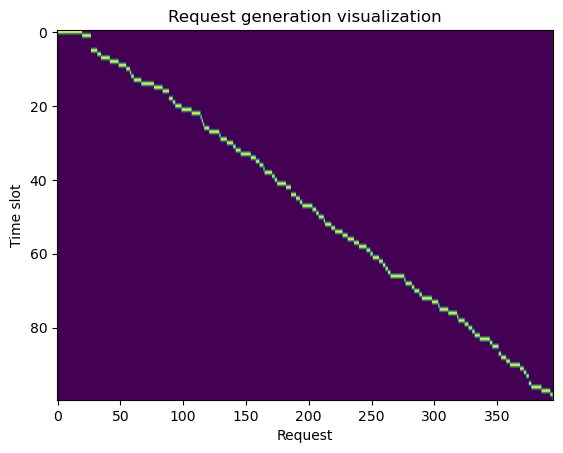

In [26]:
filepath = "./data/nsf/network.txt"
randseed = 0
max_time_unit = 100

requests = generate_request_set(filepath, randseed=randseed, time_unit=max_time_unit)
output_filename = "%s_%s_request.csv"%(randseed, max_time_unit)
write_requests_to_file("./data/nsf/request/%s"%(output_filename), requests)
visualize_generated_requests(requests)
# print(requests)
